## Load Packages

In [1]:
%matplotlib notebook
import util

## Load data and crop EELS

In [2]:
# Initialize postprocessing
analyse = util.PostProcessor()
# Load data
# poisson_noise... spectra corrupted by poisson noise
analyse.load_data(poisson_noise = True)

<IPython.core.display.Javascript object>


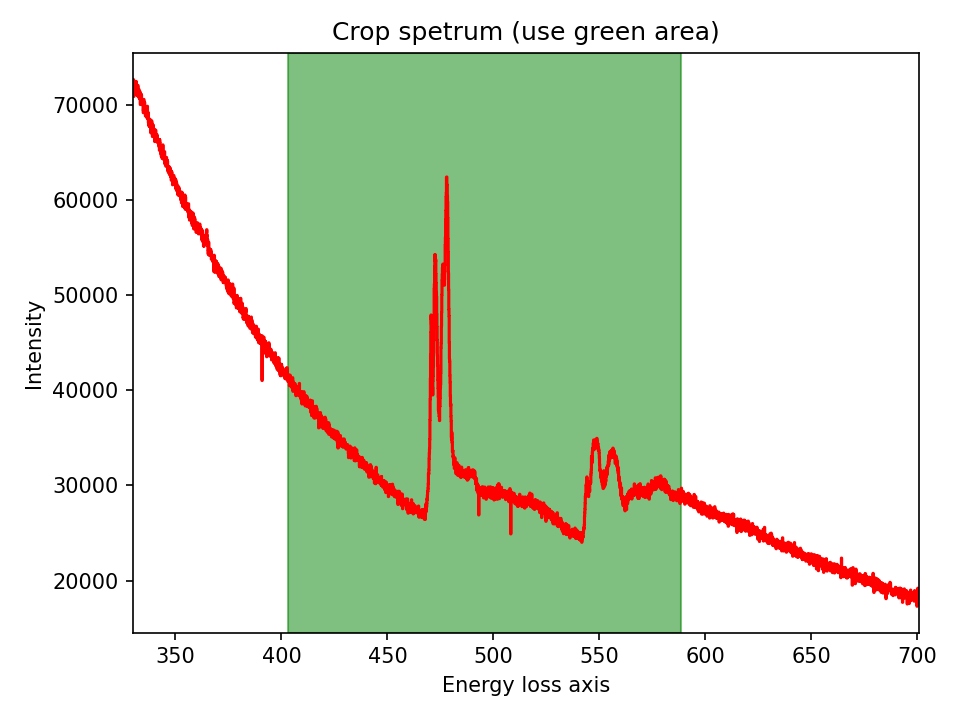

In [3]:
# Select cropping range for EELS
analyse.select_crop()

In [4]:
# Crop EELS
analyse.crop()

Crop Region from 403.00 eV to 588.40 eV


## Clustering

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


<IPython.core.display.Javascript object>


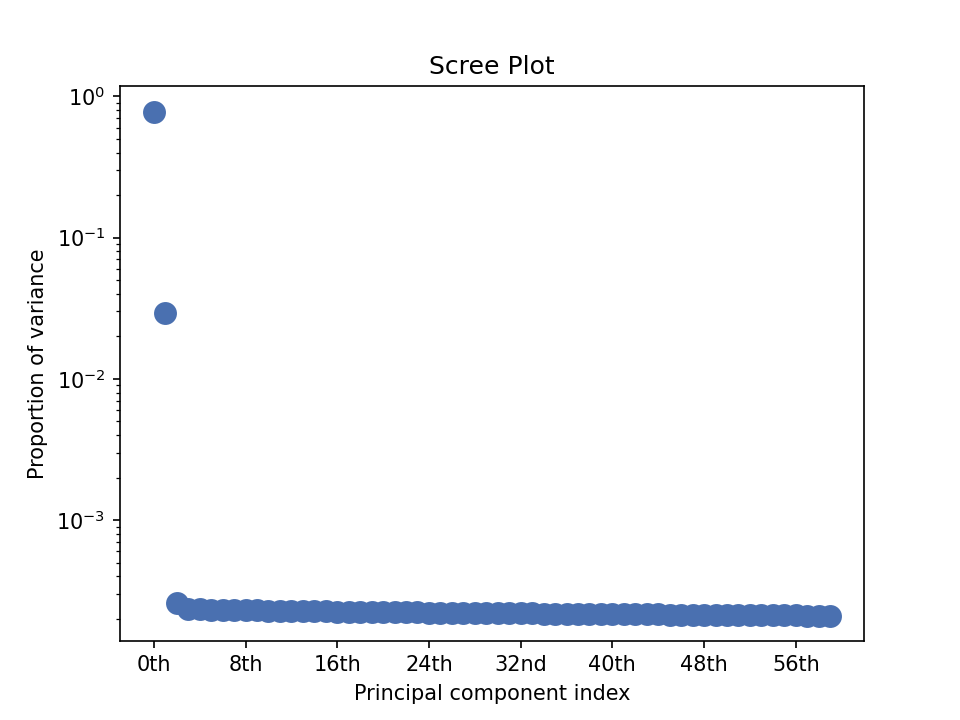

In [5]:
# Initialize clustering (PCA decomposition)
# n_plot... number of components for plotting scree plot
analyse.cluster_pca(n_plot = 60)

<IPython.core.display.Javascript object>


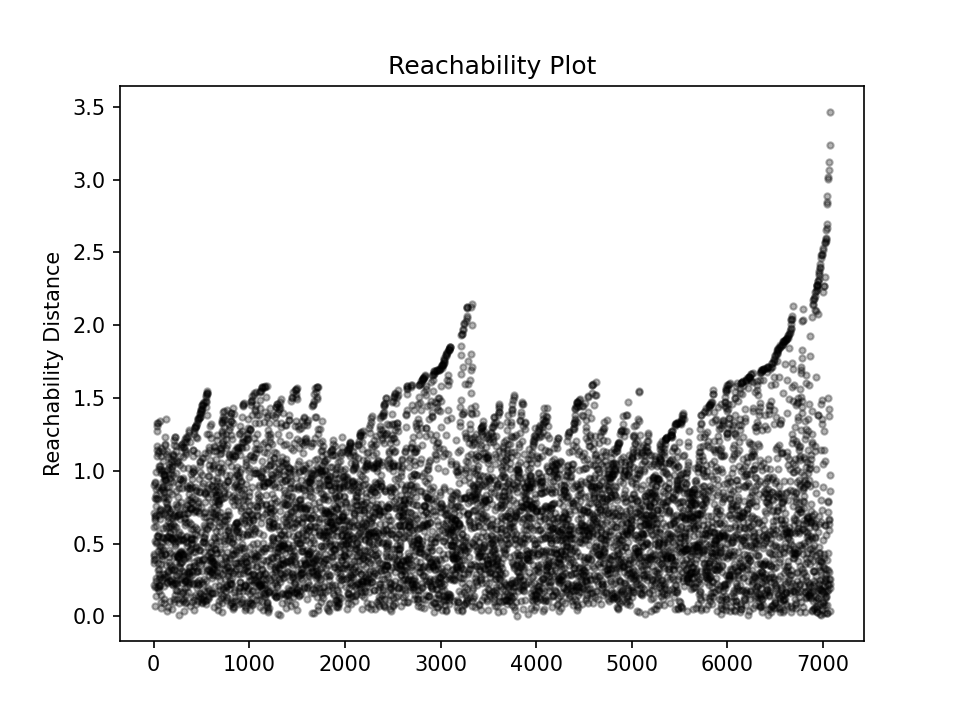

In [6]:
# Dimension reduction with t-SNE
# n_denoise_cluster... number of components for denoising for clustering
# perplexity_tsne... t-SNE - related to the number of nearest neighbors that is used in other manifold learning algorithms (between 5 to 50)
analyse.clustering_init(n_denoise_cluster = 10, perplexity_tsne = 30)

<IPython.core.display.Javascript object>


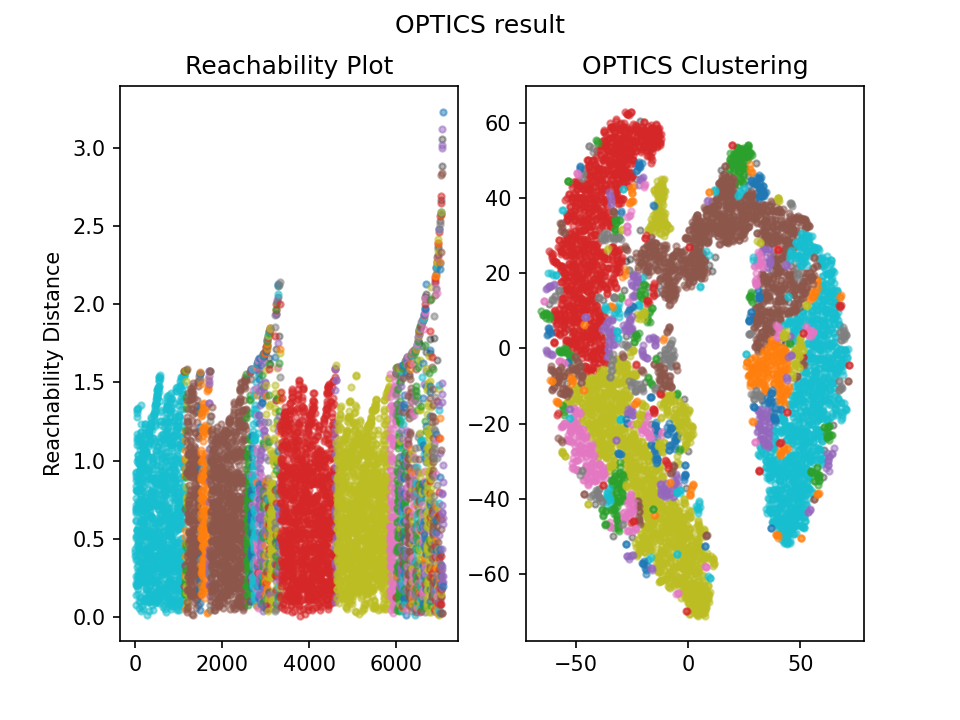

<IPython.core.display.Javascript object>


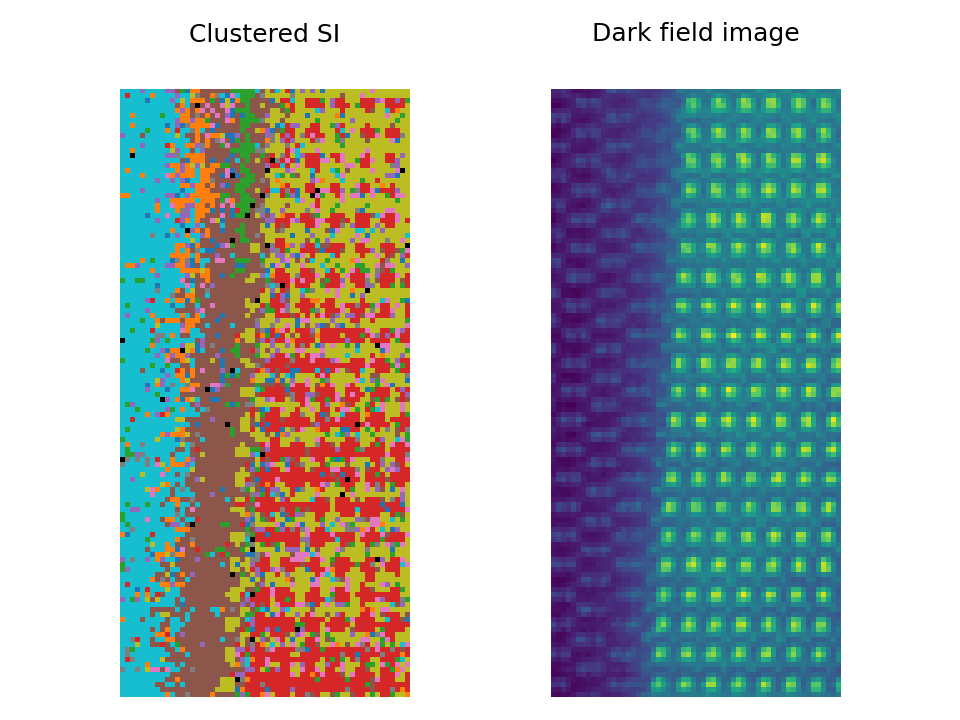

In [9]:
# OPTICS clustering
# eps_optics... estimate from reacability plot for clustering
analyse.clustering(eps_optics = 1.55)

Number of clusters for plotting: 4


<IPython.core.display.Javascript object>


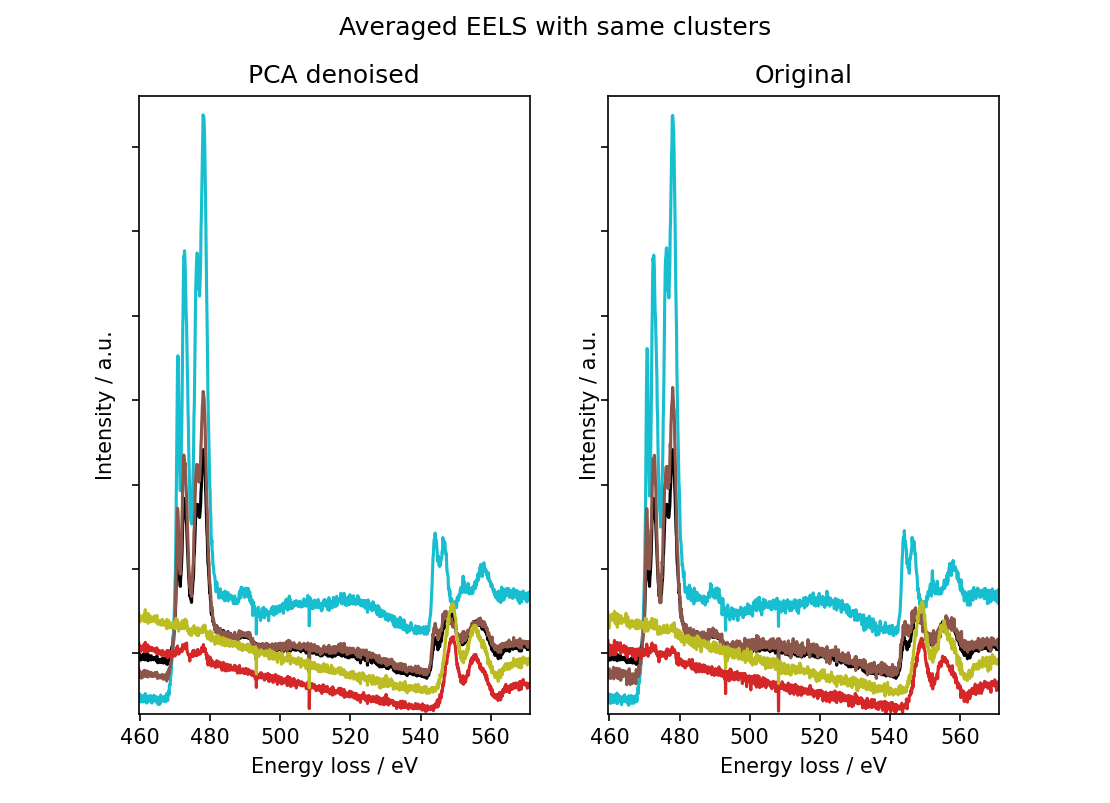

In [10]:
# Average spectra of same cluster
# k_min... minimum of points of the same cluster
analyse.clustering_spectra(k_min = 400)

## Find atom positions

<IPython.core.display.Javascript object>


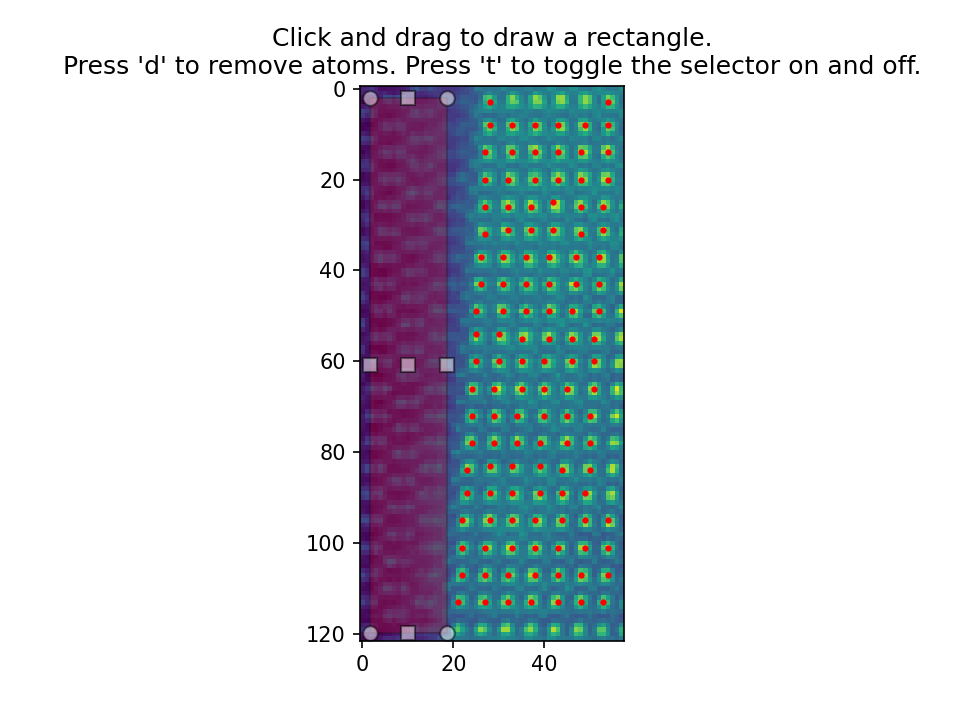

In [13]:
# Determine atom positions
# s_low... minimum distance between atoms in pixel
analyse.atom_positioning(s_low = 3)

# Remove atoms
Selector = util.atom_selector(analyse.atom_positions, analyse.s_darkfield.data, map_label = False)

<IPython.core.display.Javascript object>


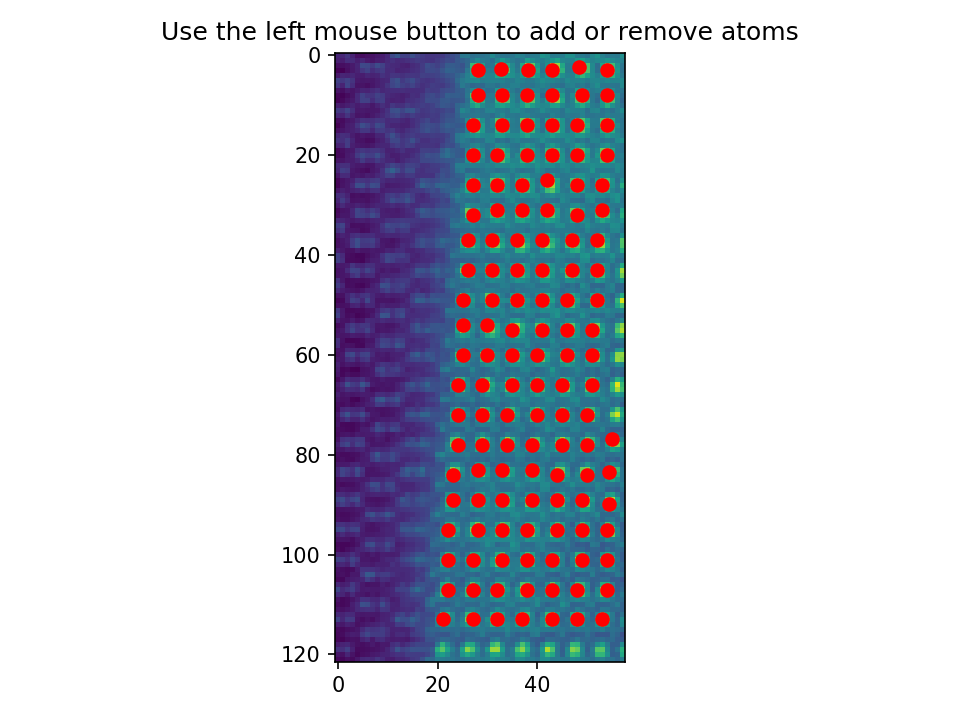

In [14]:
# Add/Remove single atoms - close figure after finishing selecting
analyse.atom_positions = Selector.atom_positions
analyse.atom_positioning_single(analyse.s_darkfield.data, analyse.atom_positions, drift_corrected = False)

Center of mass:   0%|          | 0/127 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/127 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


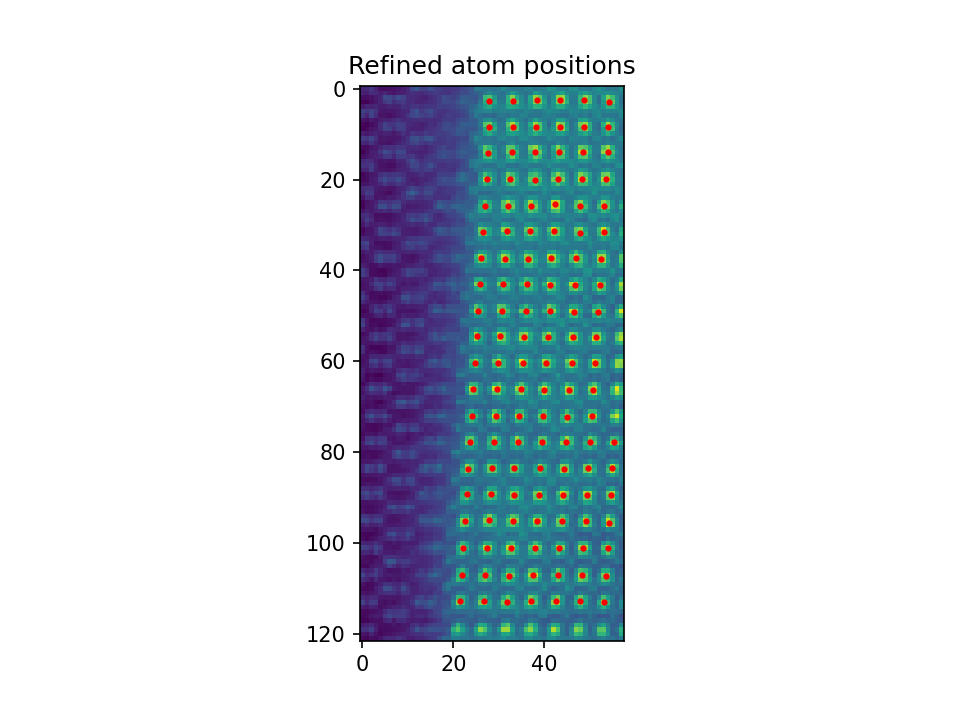

In [15]:
# Refine atom positions
analyse.refine_positions()

<IPython.core.display.Javascript object>


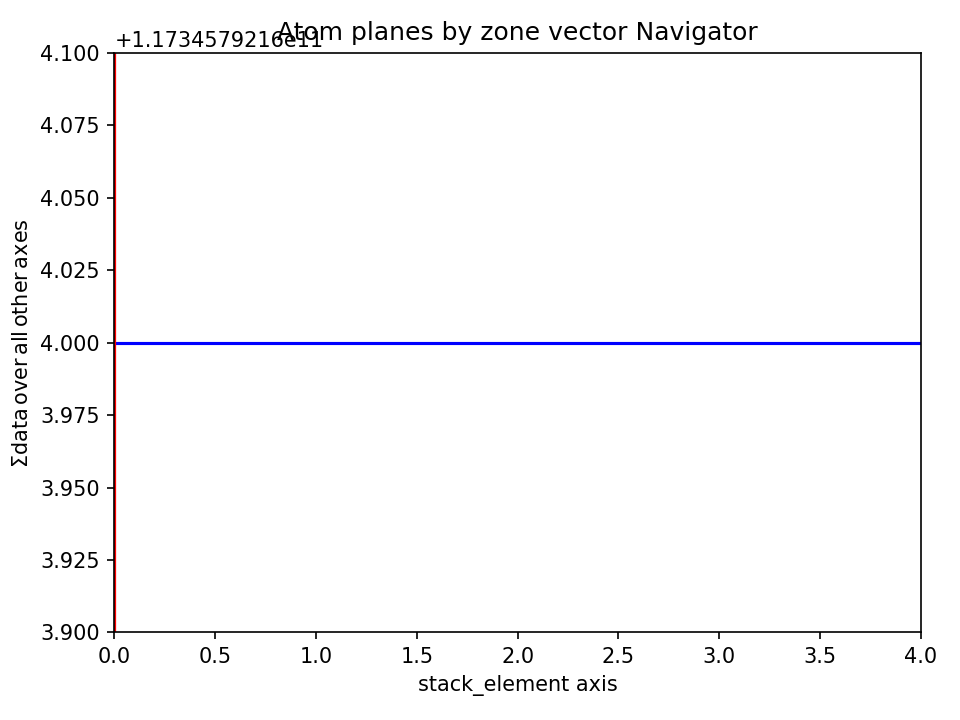

<IPython.core.display.Javascript object>


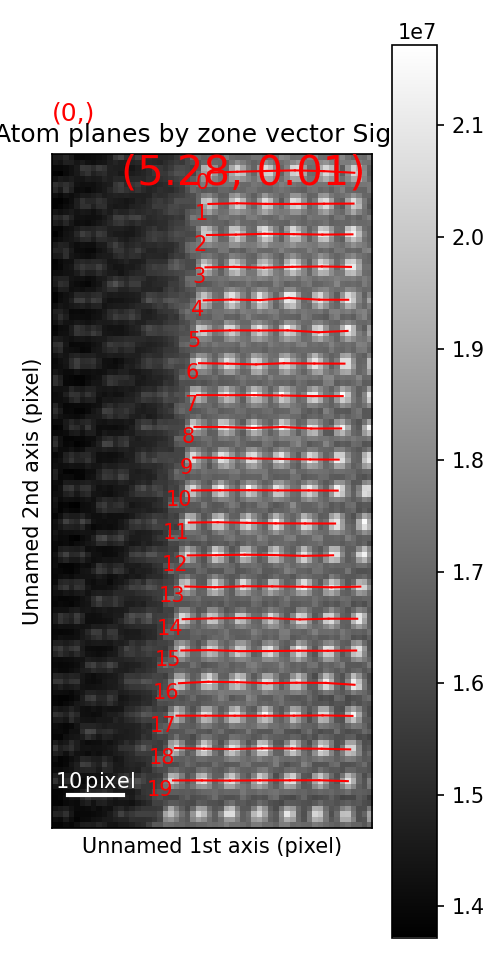

In [16]:
# Calculate laticce vectors
analyse.lattice_calc()

<IPython.core.display.Javascript object>


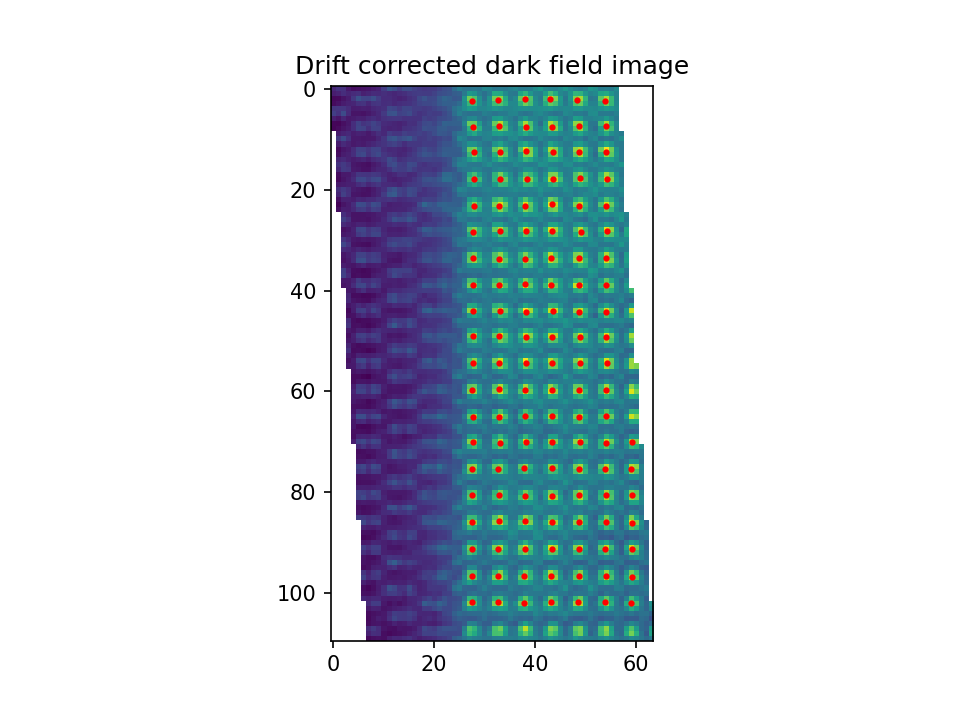

In [17]:
# Drift correction
# vector_ind... select index from lattice above to match the x_crystal and y_crystal vectors
# crystal_x... vector_ind[0] vector is shifted to crystal_x
# crystal_y... vector_ind[1] vector is shifted to crystal_y
analyse.drift_correction(vector_ind = [0,1], crystal_x = [1,0], crystal_y = [0,1])

## Stacking & Aligning

<IPython.core.display.Javascript object>


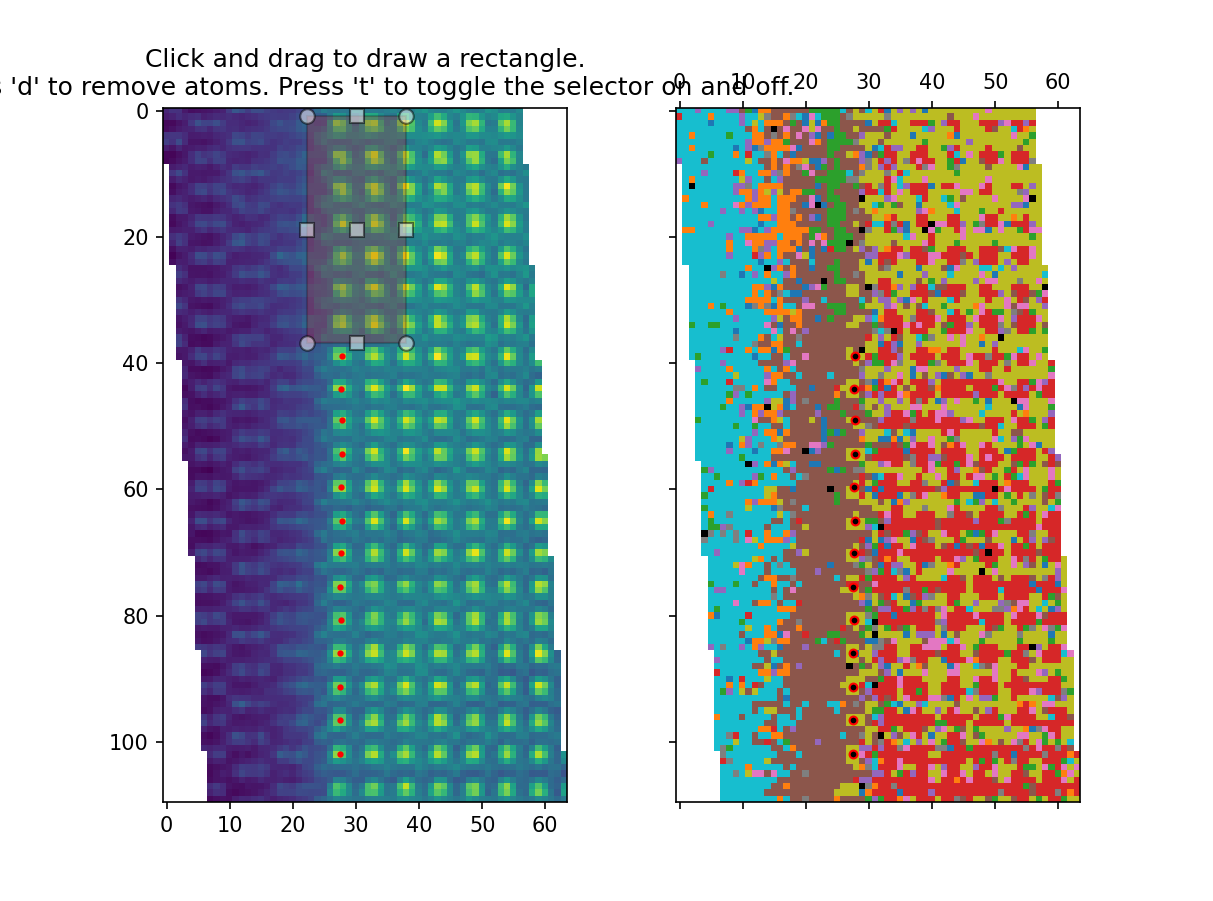

In [18]:
# Choose atoms for stacking
Selector = util.atom_selector(analyse.atom_position_drift, analyse.darkfield_drift, analyse.labels_shaped_drift, analyse.newcmp, map_label = True)

<IPython.core.display.Javascript object>


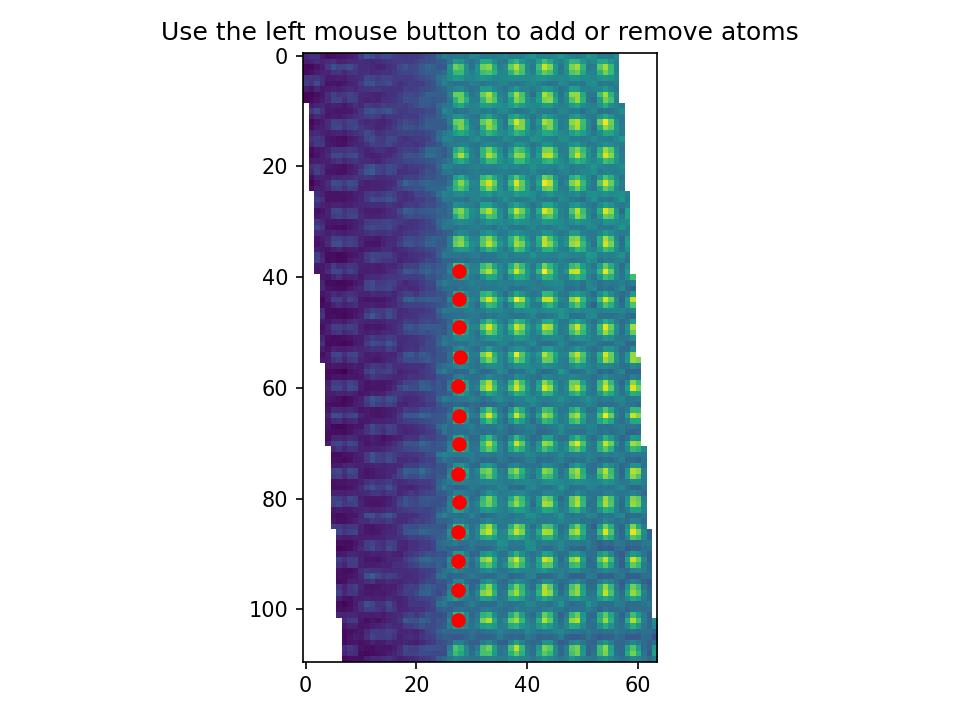

In [19]:
# Add/Remove single atoms for stacking - close figure after finishing selecting
analyse.atom_position_drift = Selector.atom_positions
analyse.atom_positioning_single(analyse.darkfield_drift, analyse.atom_position_drift, drift_corrected = True)

<IPython.core.display.Javascript object>


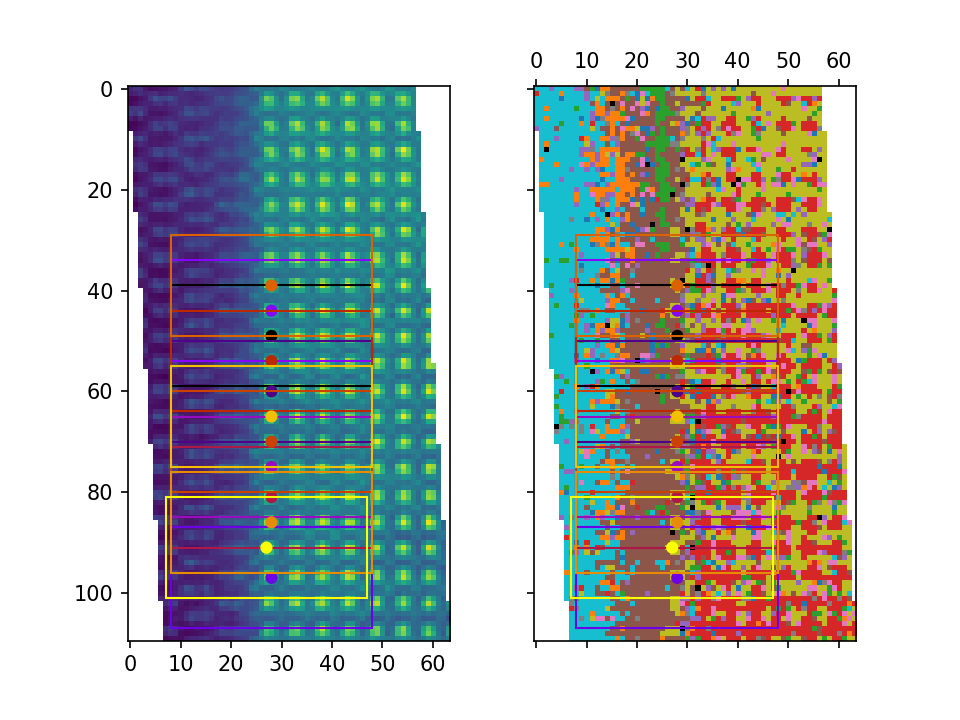

Number of cells: 12


In [20]:
# Crop cells and stack them
# width... width of the cells in pixels
# height... height of the cells in pixels
analyse.stacking(width = 40, height = 20)

1 of 2 rigid registration
2 of 2 rigid registration
1 of 2 non-rigid registration
Frame 1 converged after 24 iterations.
Frame 4 converged after 0 iterations.
Frame 8 converged after 20 iterations.
Frame 9 converged after 12 iterations.
Frame 10 converged after 0 iterations.
Frame 11 converged after 0 iterations.
Frame 12 converged after 36 iterations.
2 of 2 non-rigid registration
Frame 1 converged after 0 iterations.
Frame 2 converged after 12 iterations.
Frame 3 converged after 14 iterations.
Frame 4 converged after 0 iterations.
Frame 5 converged after 5 iterations.
Frame 6 converged after 17 iterations.
Frame 7 converged after 11 iterations.
Frame 8 converged after 0 iterations.
Frame 9 converged after 0 iterations.
Frame 10 converged after 0 iterations.
Frame 11 converged after 0 iterations.
Frame 12 converged after 0 iterations.


<IPython.core.display.Javascript object>


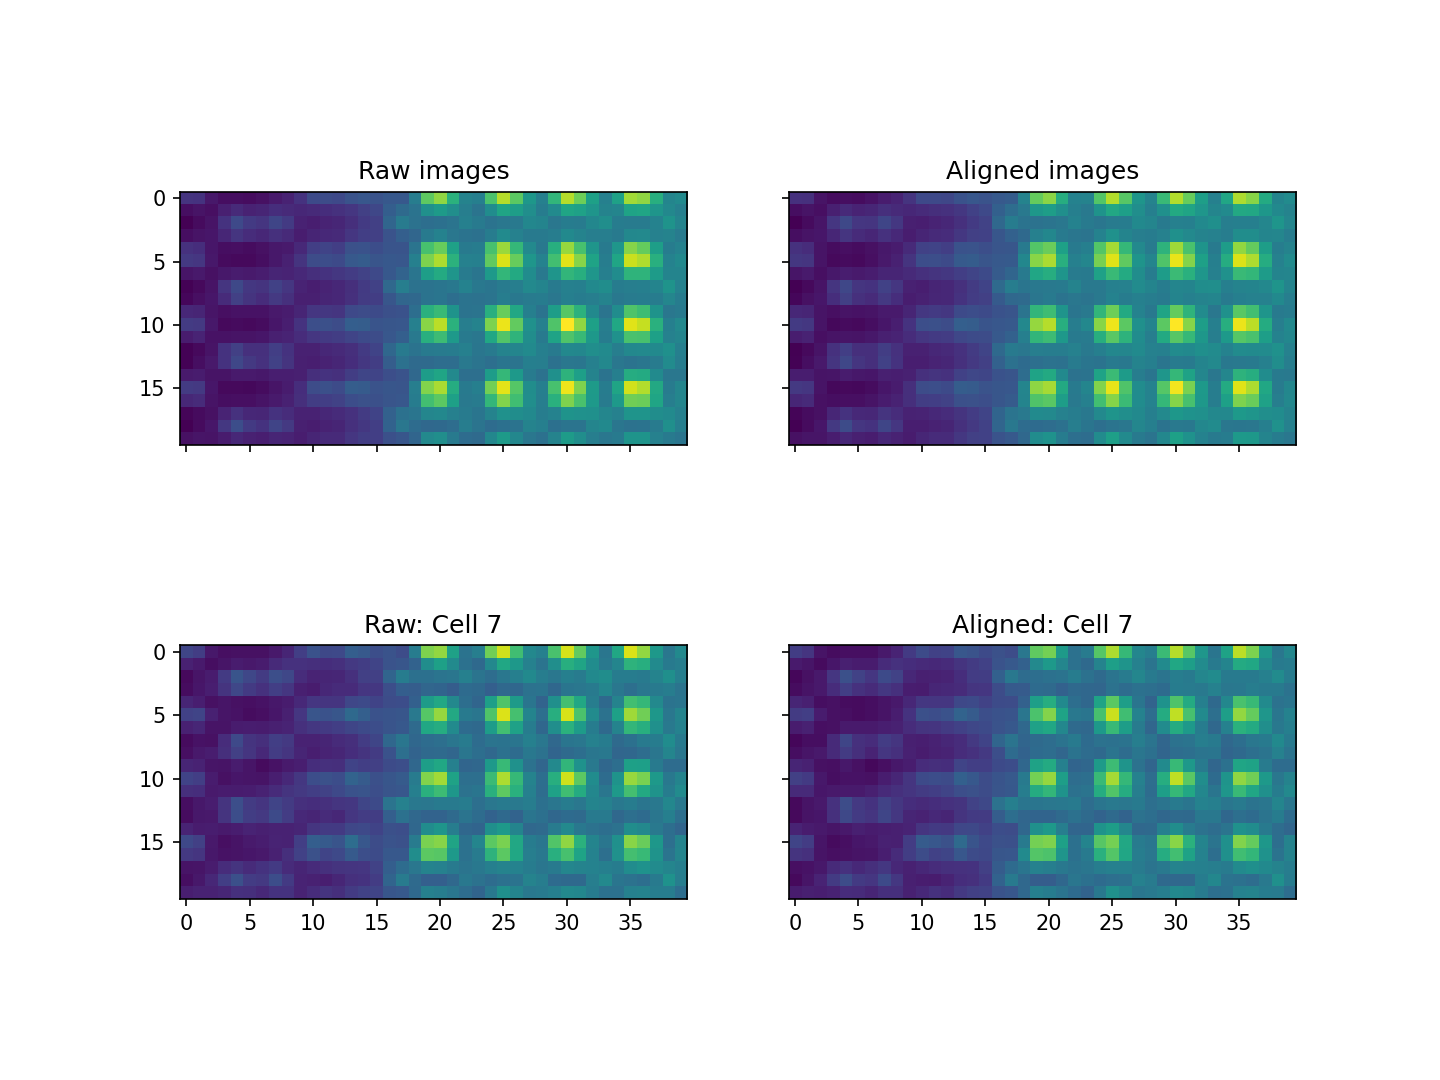

In [21]:
# Alinging according SmartAlign algorithm
# i_rigid... Iterations of rigid alignment
# max_shift... Maximum rigid shift (finds maximum correlation within these limits)
# i_non_rigid_it... Iterations of non-rigid alignment
# i_non_rigid_max... Iteration of non-rigid alignment for each cell
# row... Lock distortion field ('fitted'... linear fit in distortion)

aligner = util.Aligner(analyse.dark_field_stack)

aligner.rigid_align(i_rigid = 2, max_shift = (6, 6))
aligner.non_rigid_align(i_non_rigid_it = 2, i_non_rigid_max = 50, row = 'locked')

aligner.plot_aligned()

## L2-norm

<IPython.core.display.Javascript object>


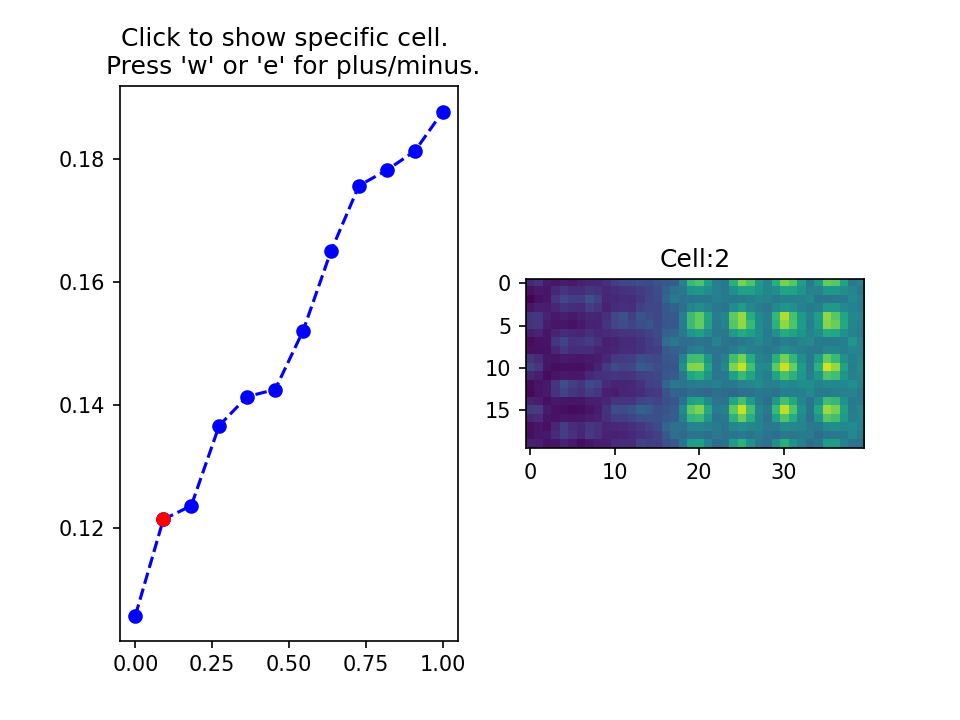

In [22]:
# Calculate L2-norm
# norming... Norming function for each cell ('max'... divide by cell maximum, 'mean'... divide by cell mean, 'kernel'... gaussian smoothing)
analyse.darkfield_aligned = aligner.image_align
darkfield_aligned_norm = analyse.L2_init(norming = 'mean')
util.L2_Selector(darkfield_aligned_norm, analyse.L2_norm)

Number of total slices: 12
Number of slices after L2-norm: 12


<IPython.core.display.Javascript object>


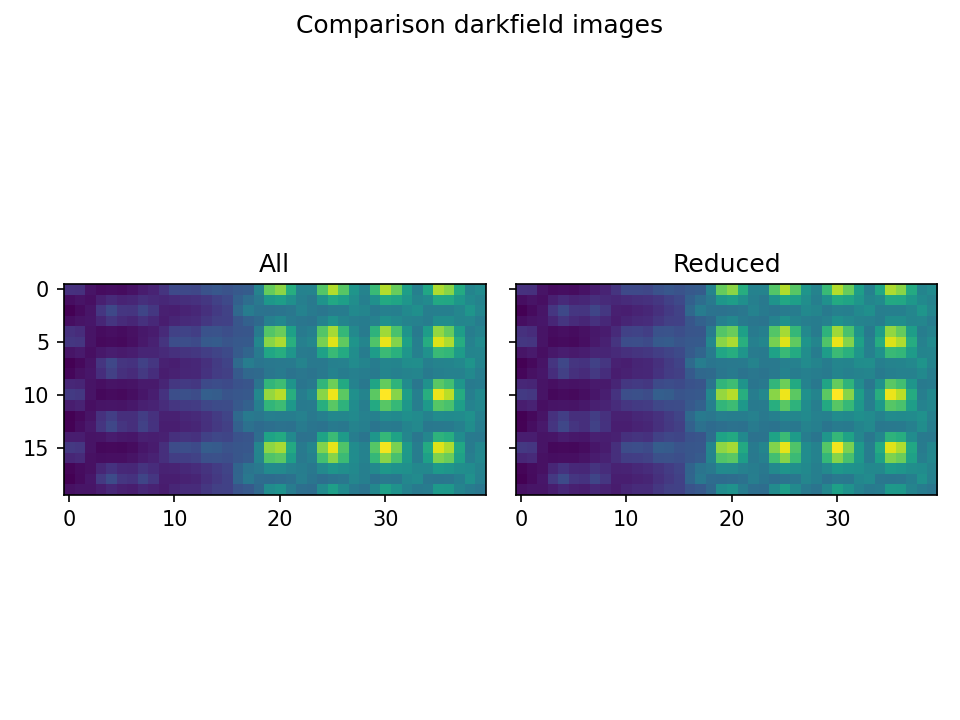

In [25]:
# Keep percentage of best slices
# n_ratio... Percentage of cells which should be kept
# norming... Use same norming function as above
analyse.L2_norm_process(n_ratio = 1, norming = 'mean')

In [26]:
# Align EELS-signal
analyse.EELS_sum_aligned = aligner.align_second(analyse.EELS, analyse.index_image_stack, analyse.slice_L2_excluded)

  0%|          | 0/12 [00:00<?, ?it/s]

## Fine structure mapping

<IPython.core.display.Javascript object>


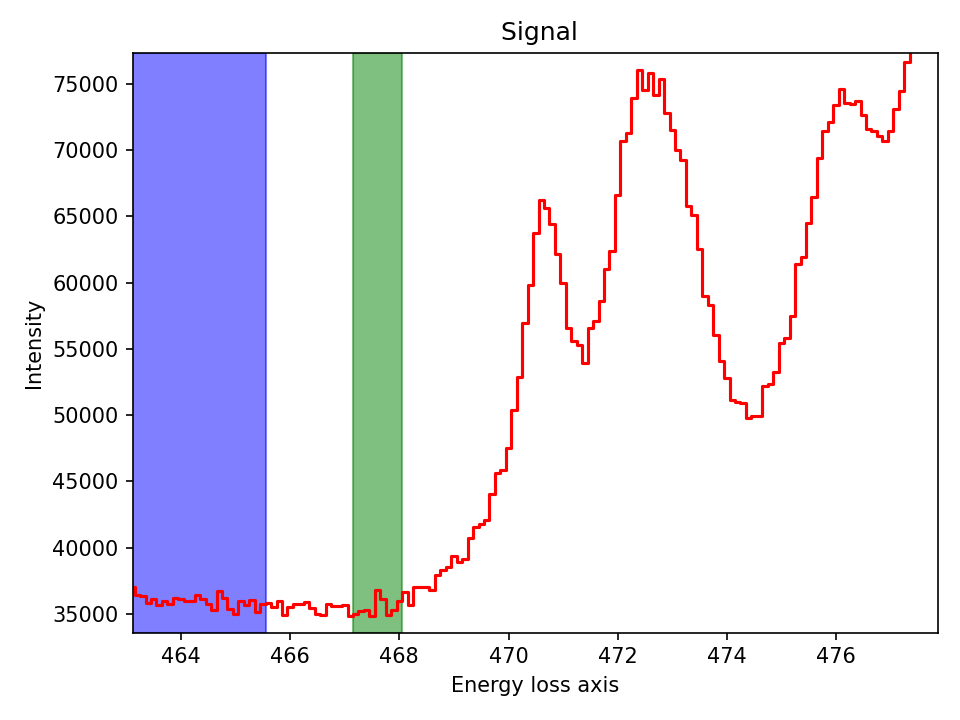

blue: Background
green: Signal


In [39]:
# Determine background and signal
analyse.EELS_region()

Background: 62.60 eV from 403.00 eV to 465.60 eV
Signal: 0.90 eV from 467.20 eV to 468.10 eV


<IPython.core.display.Javascript object>


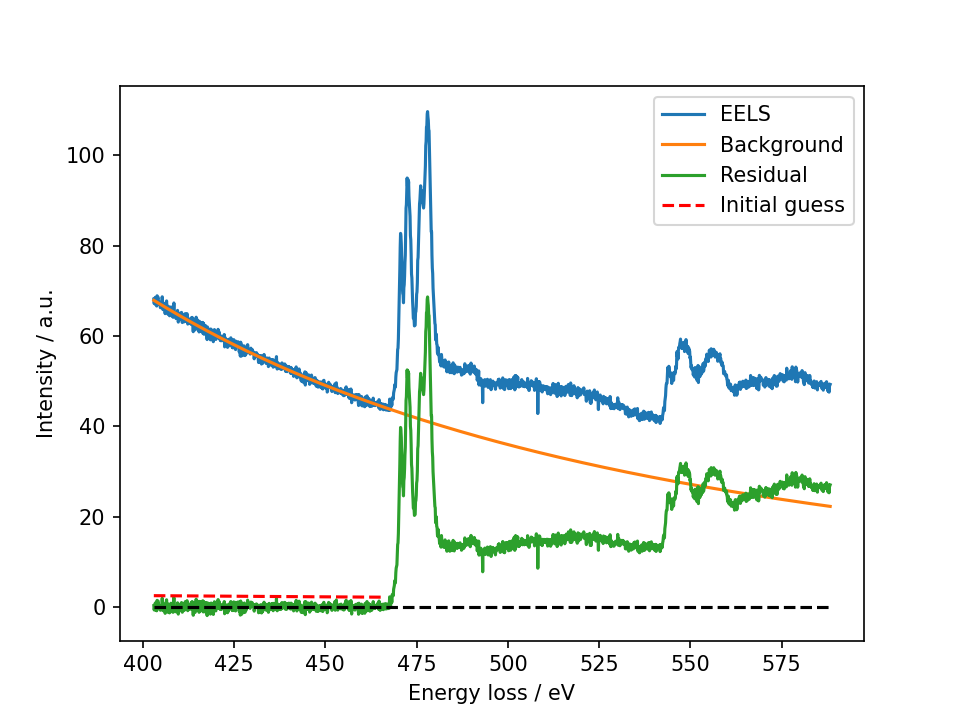

In [40]:
# Plot background and signal
# background_fun... Background function ('PowerLaw' or 'Exponential')
analyse.EELS_background(background_fun = 'Powerlaw')

Result already exist! Overwrite files? [y/n]y


<IPython.core.display.Javascript object>


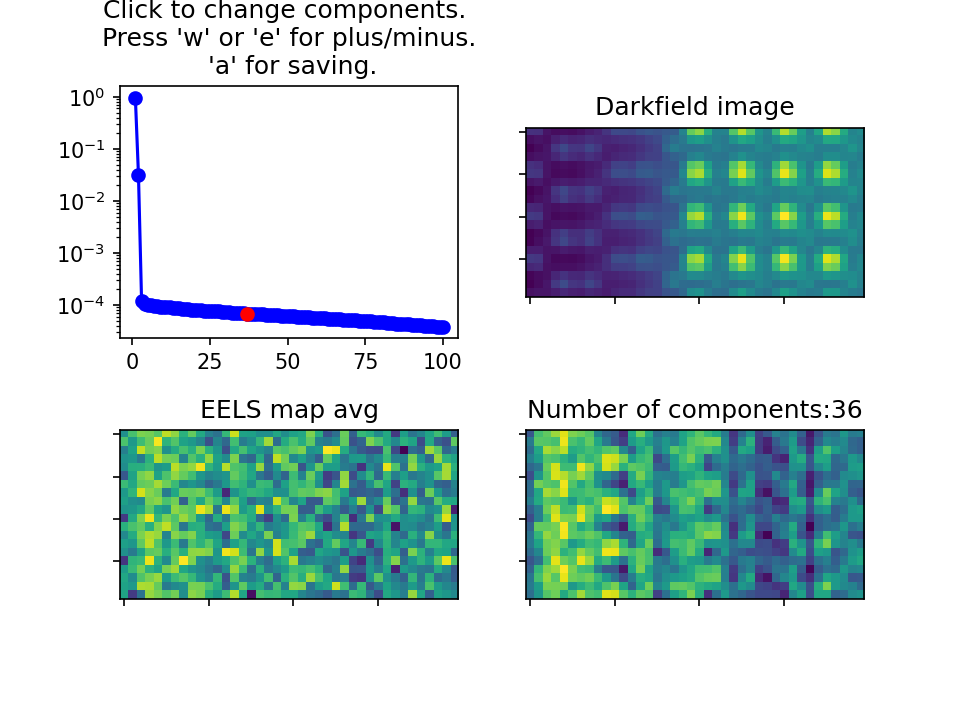

  0%|          | 0/20 [00:00<?, ?it/s]

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


  0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
# Interactive estimation of PCA-components
# d_neighbour... use neighbour for averaging for background subtraction
# background_removal_pca... PCA denoising for background subtraction - estimated background will be subtracted from the raw data
# n_back... Number of components for background_removal_pca
util.Selector_pca(analyse, d_neighbour = 0, background_removal_pca = False, n_back = 10)